In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import ops_utilities as opsu

<font size=5> 测试：自动生成 tag </font>

In [2]:
# 实例化
opsa_tag = opsu.pre.OpenSeesEasy()


# 测试 生成 十万个节点
num = 100_000
# num = 100


start_1 = time.time()
# 原生模型 域
ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6)
for i in range(num):
    ops.node(i + 1, 0.0, 0.0, 0.0)
print(f"（原生）生成 {num} 个节点 耗时 {time.time() - start_1} 秒")
num_tag_raw = ops.getNodeTags()
print(f"（原生） 域中最后一个节点 tag '{num_tag_raw[-1]}'")


start_2 = time.time()
# 模型 域
opsa_tag.wipe()
opsa_tag.model('basic', '-ndm', 3, '-ndf', 6)
for i in range(num):
    opsa_tag.node(0.0, 0.0, 0.0)
print(f'（自动 tag）生成 {num} 个节点 耗时 {time.time() - start_2} 秒')
num_tag = ops.getNodeTags()
print(f"（自动 tag） 域中最后一个节点 tag '{num_tag[-1]}'")


（原生）生成 100000 个节点 耗时 0.09820985794067383 秒
（原生） 域中最后一个节点 tag '100000'
（自动 tag）生成 100000 个节点 耗时 0.5011975765228271 秒
（自动 tag） 域中最后一个节点 tag '100000'


<font size=5> 测试：不清空既有域生成 tag </font>

In [3]:
# 实例化
opsa_ues = opsu.pre.OpenSeesEasy()

# 测试 生成 十万个节点
num = 100_000
# num = 100

# 统一使用 原生域
ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6)


start_1 = time.time()
for i in range(num):
    ops.node(i + 1, 0.0, 0.0, 0.0)
print(f"（原生）生成 {num} 个节点 耗时 {time.time() - start_1} 秒")
num_tag_raw = ops.getNodeTags()
print(f"（原生） 域中最后一个节点 tag '{num_tag_raw[-1]}'")


start_2 = time.time()
for i in range(num):
    opsa_ues.node(0.0, 0.0, 0.0)
print(f"（自动 tag）生成 {num} 个节点 耗时 {time.time() - start_2} 秒")
num_tag = ops.getNodeTags()
print(f"（自动 tag） 域中最后一个节点 tag '{num_tag[-1]}'")


（原生）生成 100000 个节点 耗时 0.08483266830444336 秒
（原生） 域中最后一个节点 tag '100000'
（自动 tag）生成 100000 个节点 耗时 0.4699420928955078 秒
（自动 tag） 域中最后一个节点 tag '200000'


<font size=5> 测试：管理器协作 </font>

In [4]:
# 实例化
opsa_m = opsu.pre.OpenSeesEasy()

# 定义域
opsa_m.wipe()
opsa_m.model('basic', '-ndm', 3, '-ndf', 6)

In [5]:
# node
center = opsa_m.node(0.0, 0.0, 0.0) # tag 起点 默认值为 1
upper = opsa_m.node(0.0, 0.0, 1.0, tag=10) # 显式输入 tag 起点
left = opsa_m.node(-1.0, 0.0, 0.0)
right = opsa_m.node(1.0, 0.0, 0.0)
lower = opsa_m.node(0.0, 0.0, -1.0, tag=20) # 配置新起点
lower_1 = opsa_m.node(0.0, -1.0, -1.0)
lower_2 = opsa_m.node(1.0, -1.0, -1.0)
print(f"检查返回的 tag: \n \
    center: {center}, \n \
    upper: {upper}, left: {left}, right: {right}, \n \
    lower: {lower}, lower_1: {lower_1}, lower_2: {lower_2}"
    )

检查返回的 tag: 
     center: 1, 
     upper: 10, left: 11, right: 12, 
     lower: 20, lower_1: 21, lower_2: 22


In [6]:
# material
ops.uniaxialMaterial('Steel02', 2, *(400., 200.e3, 0.01), *(18, 0.925, 0.15)) # 原生命令 tag = 2
ops.uniaxialMaterial('Elastic', 3, 1.e10) # 原生命令 tag = 3

bar = opsa_m.uniaxialMaterial('Steel02', *(400., 200.e3, 0.01), *(18, 0.925, 0.15)) # 自动 tag = 1
cover = opsa_m.uniaxialMaterial('Concrete04', 40., -0.002, -0.0033, 28.e3) # 自动 tag = 4
core = opsa_m.uniaxialMaterial('Concrete04', 40., -0.033, -0.004, 28.e3) # 自动 tag = 5

print(f"bar = {bar}, cover = {cover}, core = {core}")

bar = 1, cover = 4, core = 5


In [7]:
# 查看每部管理器
MM_in = opsa_m.get_manager()
print(f"查看内部管理器（原始）：\n{MM_in}")

# 设置 label
MM_in.set_label('node', center, 'center')
MM_in.set_label('uniaxialMaterial', bar, 'bar')
MM_in.set_label('uniaxialMaterial', cover, 'cover')
MM_in.set_label('uniaxialMaterial', core, 'core')

# 设置 group
MM_in.set_group('node', [upper, right, left], 'start 10')
MM_in.set_group('node', [lower, lower_1, lower_2], 'start 20')

# 查看 管理器
print(f"\n查看内部管理器（修改后）：\n{MM_in}")
print(f"\n获取 tag：{MM_in.get_tag('node', label='center')}")
print(f"\n获取 tag：{MM_in.get_tag('node', group='start 10')}")


查看内部管理器（原始）：
           category tag label group params
0              node  22                   
1              node   1                   
2  uniaxialMaterial   1                   
3              node  12                   
4  uniaxialMaterial   4                   
5  uniaxialMaterial   5                   
6              node  10                   
7              node  21                   
8              node  11                   
9              node  20                   

查看内部管理器（修改后）：
           category tag   label     group params
0              node  22          start 20       
1              node   1  center                 
2  uniaxialMaterial   1     bar                 
3              node  12          start 10       
4  uniaxialMaterial   4   cover                 
5  uniaxialMaterial   5    core                 
6              node  10          start 10       
7              node  21          start 20       
8              node  11          start 10       
9        

In [8]:
# 实例化管理器
MM = opsu.pre.ModelManager(node=15, element=15, uniaxialMaterial=1000)

# 管理器添加内容
for i in range(10):
    MM.next_tag('node', group='pre-node')
for i in range(10):
    MM.next_tag('element', group='pre-element')
for i in range(5):
    MM.next_tag('uniaxialMaterial', group='pre-material')

print(f"查看管理器：\n{MM}")


查看管理器：
            category   tag label         group params
0               node    15            pre-node       
1               node    16            pre-node       
2               node    17            pre-node       
3               node    18            pre-node       
4               node    19            pre-node       
5               node    20            pre-node       
6               node    21            pre-node       
7               node    22            pre-node       
8               node    23            pre-node       
9               node    24            pre-node       
10           element    15         pre-element       
11           element    16         pre-element       
12           element    17         pre-element       
13           element    18         pre-element       
14           element    19         pre-element       
15           element    20         pre-element       
16           element    21         pre-element       
17           element 

In [9]:
# 添加管理器，覆盖内部既有管理器
opsa_m.add_manager(MM)
for i in range(20):
    opsa_m.node(1., 1., 1.)

# 获取管理器
MM_2 = opsa_m.get_manager()
print(f"当前管理器中的节点：{MM_2.get_tag('node')}")
print(f"当前管理器：")
MM_2

当前管理器中的节点：[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 20, 21, 21, 22, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
当前管理器：


,category,tag,label,group,params
0,node,15,,pre-node,
1,node,16,,pre-node,
2,node,17,,pre-node,
3,node,18,,pre-node,
4,node,19,,pre-node,
5,node,20,,pre-node,
6,node,21,,pre-node,
7,node,22,,pre-node,
8,node,23,,pre-node,
9,node,24,,pre-node,


In [10]:
# 清空
opsa_m.wipe()
print(f"\n查看内部管理器（清空后）：\n{opsa_m.get_manager()}")


查看内部管理器（清空后）：
Empty DataFrame
Columns: [category, tag, label, group, params]
Index: []


<font size=5> 测试：报错 </font>

In [11]:
opsa_e = opsu.pre.OpenSeesEasy(MM)

opsa_e.wipe()
opsa_e.model('basic', '-ndm', 3, '-ndf', 6)

try:
    opsa_e.node(*(1., 1.,), lim=0.1) # lim 参数限制尝试时间，单位：秒
except Exception as e:
    print(f"报错信息 1：{e}")

try:
    opsa_e.node(*(1., 1., 1.), tag=float(1)) # lim 参数限制尝试时间，单位：秒
except Exception as e:
    print(f"报错信息 2：{e}")

报错信息 1：Failed to allocate tag. See more information: 
e:\GitHub\Opspy\OpspyCases\.OpenSeesEasy.log
报错信息 2：Tag must be an integer.


<font size=5> 测试： < 创建单元 > 嵌套  < 创建节点 > </font>

In [12]:
opsa = opsu.pre.OpenSeesEasy()

opsa.wipe()
opsa.model('basic', '-ndm', 3, '-ndf', 6)

# 材料
mat = opsa.uniaxialMaterial('Elastic', 200.e3)
# 节点
top = opsa.node(0.5, 0.5, 1.)
# 单元
opsa.element(
    'truss', *(top, opsa.node(0., 0., 0.)),
    1., mat,
    )
opsa.element(
    'truss', *(top, opsa.node(1., 0., 0.)),
    1., mat,
    )
opsa.element(
    'truss', *(top, opsa.node(0., 1., 0.)),
    1., mat,
    )
opsa.element(
    'truss', *(top, opsa.node(1., 1., 0.)),
    1., mat,
    )

opsa.get_manager()

,category,tag,label,group,params
0,node,2,,,
1,element,1,,,
2,element,3,,,
3,uniaxialMaterial,1,,,
4,node,1,,,
5,element,2,,,
6,node,4,,,
7,element,4,,,
8,node,3,,,
9,node,5,,,


In [13]:
import opstool as opst
opst.vis.plotly.plot_model(show_node_numbering=True)

<font size=5> 测试： 显示纤维截面 </font>

In [14]:
opsa_s = opsu.pre.OpenSeesEasy()

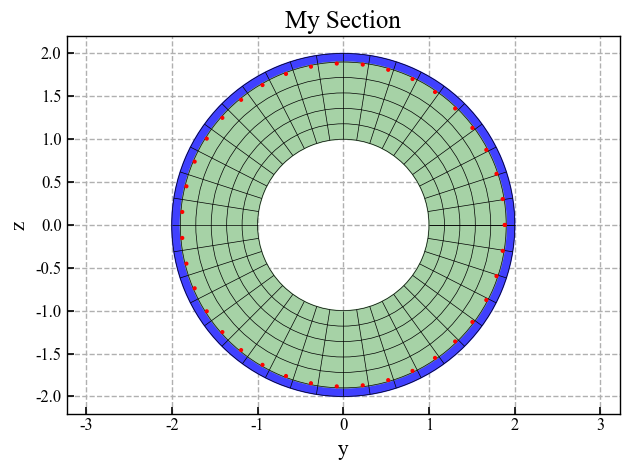

,category,tag,label,group,params
0,uniaxialMaterial,1,,,
1,section,1,,,


In [15]:
# 域
opsa_s.wipe()
opsa_s.model('basic', '-ndm', 3, '-ndf', 6)
# 材料
emat = opsa_s.uniaxialMaterial("Elastic", 1000)
# 截面
opsa_s.section("Fiber", "-GJ", 1.0e6)
opsa_s.patch("circ", emat, 40, 1, 0, 0, 1.9, 2, 0, 360, color="#4040FF", opacity=1.)
opsa_s.patch("circ", emat, 40, 5, 0, 0, 1, 1.9, 0, 360, color="#A6D2A6", opacity=1.)
opsa_s.layer("circ", emat, 40, np.pi * 0.016**2, 0, 0, 1.9 - 0.016, 0.0, 360.0, color="red")
# plot
opsa_s.plot_sec(sec_tag=1)
plt.show()
opsa_s.get_manager()

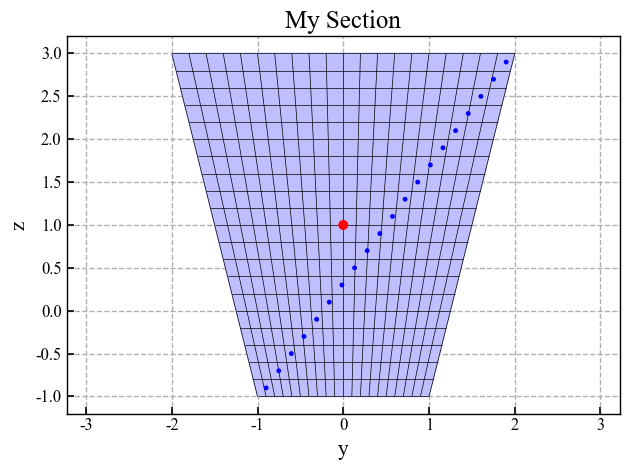

,category,tag,label,group,params
0,uniaxialMaterial,1,,,
1,section,1,,,


In [16]:
# 域
opsa_s.wipe()
opsa_s.model('basic', '-ndm', 3, '-ndf', 6)
# 材料
emat = opsa_s.uniaxialMaterial("Elastic", 1000)
# 截面
opsa_s.section("Fiber", "-GJ", 1.0e6)
opsa_s.patch("quad", emat, 20, 20, -1, -1, 1, -1, 2, 3, -2, 3, color="#BFBFFF", opacity=1.)
opsa_s.layer("straight", emat, 20, np.pi * 0.02**2, *[-0.9, -0.9], *[1.9, 2.9], color="blue")
opsa_s.fiber(0., 1., np.pi * 0.05**2, emat, color="red")
# plot
opsa_s.plot_sec(sec_tag=1)
plt.show()
opsa_s.get_manager()